# Определение стоимости автомобилей

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

In [2]:
try:
    data = pd.read_csv('autos.csv')
    
except:
    print('Ошибка загрузки данных')
    
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Проверка данных на пропуски и явные дубликаты**

In [4]:
print('Количество явных дубликатов:', data.duplicated().sum())
print()
print('Количество пропусков по столбцам', data.isna().sum(), sep='\n')

Количество явных дубликатов: 4

Количество пропусков по столбцам
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


In [5]:
# удаление явных дубликатов

data = data.drop_duplicates().reset_index(drop=True)

# заполнение пропусков 

data = data.fillna('unknown')

**Удаление неинформативных параметров**

Признаки 'DateCrawled', 'RegistrationYear', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen' не являются информативными, поэтому их рассматривать не будем.

In [6]:
data = data.drop(['DateCrawled', 'RegistrationYear', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

**Смена названий столбцов**

In [7]:
data.columns = ['Price', 'Vehicle_Type', 'Gearbox', 'Power', 'Model', 'Kilometer','Fuel_Type', 'Brand', 'Repaired']
data.columns = data.columns.str.lower()
data.columns

Index(['price', 'vehicle_type', 'gearbox', 'power', 'model', 'kilometer',
       'fuel_type', 'brand', 'repaired'],
      dtype='object')

**Графический анализ признаков**

Построение графиков для категориальных признаков

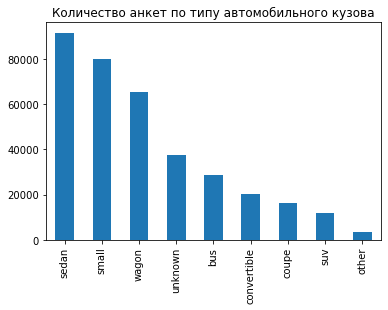

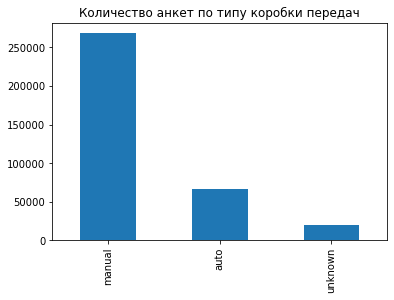

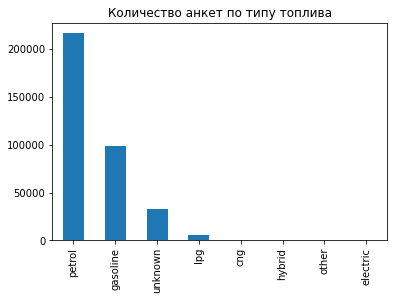

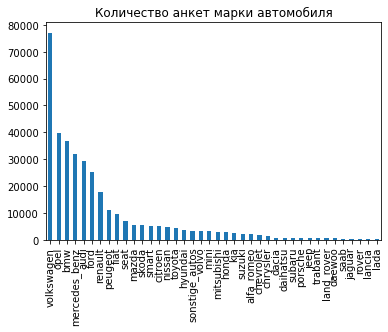

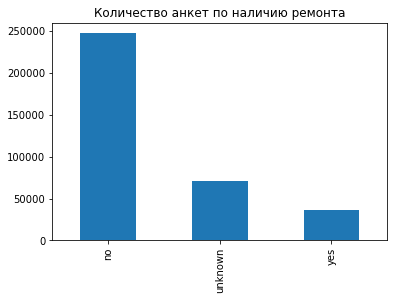

In [8]:
data['vehicle_type'].value_counts().plot(kind='bar', title = 'Количество анкет по типу автомобильного кузова')
plt.show()
data['gearbox'].value_counts().plot(kind='bar', title = 'Количество анкет по типу коробки передач')
plt.show()
data['fuel_type'].value_counts().plot(kind='bar', title = 'Количество анкет по типу топлива')
plt.show()
data['brand'].value_counts().plot(kind='bar', title = 'Количество анкет марки автомобиля')
plt.show()
data['repaired'].value_counts().plot(kind='bar', title = 'Количество анкет по наличию ремонта')
plt.show()

**Построение диаграмм размаха для количественых признаков**

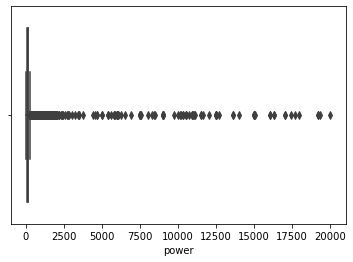

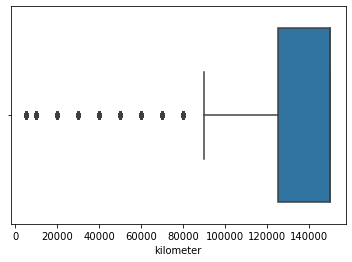

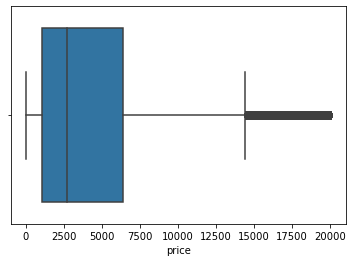

In [9]:
sns.boxplot(x=data['power'])
plt.show()

sns.boxplot(x=data['kilometer'])
plt.show()

sns.boxplot(x=data['price'])
plt.show()

**Выборка данных по столбцу "Power" и "Price"**

Ограничение выборок 5-м и 95-м квантилем :

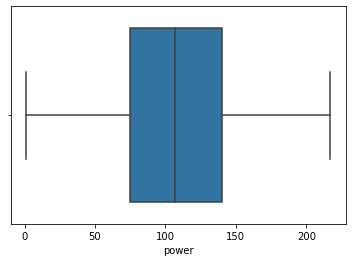

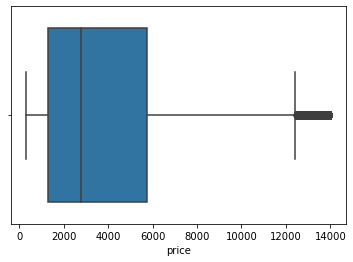

In [10]:
# выборка данных по столбцу "Power"

data = data[(data['power'] < data['power'].quantile(0.95)) & (data['power'] > data['power'].quantile(0.05))]

sns.boxplot(x=data['power'])
plt.show()

# выборка данных по столбцу "Price"

data = data[(data['price'] < data['price'].quantile(0.95)) & (data['price'] > data['price'].quantile(0.05))]

sns.boxplot(x=data['price'])
plt.show()

**Вывод**

Была произведена предобработка данных: данные проверены на пропуски с последующим их заполнением, удалены явные дубликаты. Произведён графический анализ признаков и отбор необходимых данных.

In [11]:
# import sweetviz as sv
# report = sv.analyze([data, " Autos"])
# report.show_html('Autos.html')

## Обучение моделей

**Разбиение на обучающую и тестовую выборки**

In [12]:
features = data.drop('price', axis=1)
target = data['price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

**Масштабирование количественных признаков**

In [13]:
pd.options.mode.chained_assignment = None

numeric = ['power', 'kilometer']

scaler = StandardScaler()

features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**Кодирование категориальных признаков**

Кодирование признаков 'vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired' методом OrdinalEncoder.

In [14]:
features_train_oe = features_train.copy(deep=True)
features_test_oe = features_test.copy(deep=True)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

features_train_oe[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']] =\
encoder.fit_transform(features_train_oe[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']])

features_test_oe[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']] =\
encoder.transform(features_test_oe[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']])

**Создание функции для вычисления метрики RMSE**

In [15]:
def rmse(t, p):
    return mean_squared_error(t, p) ** 0.5

rmse = make_scorer(rmse, greater_is_better=False)

**СЛУЧАЙНЫЙ ЛЕС**

**Подбор гиперпараметров**

In [16]:
parameters = {'n_estimators': range(20, 41, 5), 'max_depth': range(1, 10)}
model_rf = RandomForestRegressor(random_state=12345)
tree_grid = GridSearchCV(model_rf, parameters, scoring=rmse, cv=3, n_jobs=-1, verbose=False)
tree_grid.fit(features_train_oe, target_train)

cv_data = pd.DataFrame(tree_grid.cv_results_)
best_value = -1 * np.max(cv_data['mean_test_score'])
best_iter = np.argmax(cv_data['mean_test_score'])
print('Наилучшее значение метрики RMSE: {:.0f} при параметрах {}'.format(
best_value, cv_data['params'][best_iter]))
print('Время обучения: {:.1f}'.format(cv_data['mean_fit_time'][best_iter]))
print('Время предсказания: {:.1f}'.format(cv_data['mean_score_time'][best_iter]))

Наилучшее значение метрики RMSE: 2037 при параметрах {'max_depth': 9, 'n_estimators': 40}
Время обучения: 11.3
Время предсказания: 0.3


**МОДЕЛЬ CatBoost**

**Подбор гиперпараметров**

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

parameters = {'iterations': range(80, 100, 5)}
model_cb = CatBoostRegressor() 
cb_grid = GridSearchCV(model_cb, parameters, scoring=rmse, cv=3, n_jobs=-1, verbose=False)
cb_grid.fit(features_train, target_train, cat_features=cat_features, verbose=False)

cv_data = pd.DataFrame(cb_grid.cv_results_)
best_value = -1 * np.max(cv_data['mean_test_score'])
best_iter = np.argmax(cv_data['mean_test_score'])
print('Наилучшее значение метрики RMSE: {:.0f} при параметрах {}'.format(
best_value, cv_data['params'][best_iter]))
print('Время обучения: {:.1f}'.format(cv_data['mean_fit_time'][best_iter]))
print('Время предсказания: {:.1f}'.format(cv_data['mean_score_time'][best_iter]))

Наилучшее значение метрики RMSE: 1822 при параметрах {'iterations': 95}
Время обучения: 14.3
Время предсказания: 0.3


**МОДЕЛЬ LightBGM**

**Подбор гиперпараметров**

In [19]:
parameters = {'n_estimators': range(80, 101, 2), 'max_depth': range(1, 10)}
model_l= lgb.LGBMRegressor()
l_grid = GridSearchCV(model_l, parameters, scoring=rmse, cv=3, n_jobs=-1, verbose=10)
l_grid.fit(features_train_oe, target_train)

cv_data = pd.DataFrame(l_grid.cv_results_)
best_value = -1 * np.max(cv_data['mean_test_score'])
best_iter = np.argmax(cv_data['mean_test_score'])
print('Наилучшее значение метрики RMSE: {:.0f} при параметрах {}'.format(
best_value, cv_data['params'][best_iter]))
print('Время обучения: {:.1f}'.format(cv_data['mean_fit_time'][best_iter]))
print('Время предсказания: {:.1f}'.format(cv_data['mean_score_time'][best_iter]))

Fitting 3 folds for each of 99 candidates, totalling 297 fits
Наилучшее значение метрики RMSE: 1877 при параметрах {'max_depth': 9, 'n_estimators': 100}
Время обучения: 1.9
Время предсказания: 0.6


## Анализ моделей

In [23]:
data = pd.DataFrame({'Случайный лес': [2037, 11.3, 0.3], 'CatBoost': [1822, 14.3, 0.3], 
                     'LightGBM': [1877, 1.9, 0.6]}, 
                    index=['RMSE на обучающей выборке', 'Время обучения, с', 'Время предсказания, с'])

print('Сводная таблица значений RMSE и времён обучения и предсказания моделей')
data

Сводная таблица значений RMSE и времён обучения и предсказания моделей


,Случайный лес,CatBoost,LightGBM
RMSE на обучающей выборке,2037.0,1822.0,1877.0
"Время обучения, с",11.3,14.3,1.9
"Время предсказания, с",0.3,0.3,0.6


**Вывод**

После сравнительного анализа наиболее эффективной моделью была выбрана модель CatBoost.

## Тестирование модели

In [25]:
# обучение наилучшей модели

cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

model_cb = CatBoostRegressor(iterations=95) 
model_cb.fit(features_train, target_train, cat_features=cat_features, verbose=False)
print('Значение метрики RMSE на тестовой выборке {:.0f}'.\
      format(mean_squared_error(model_cb.predict(features_test), target_test) ** 0.5))

Значение метрики RMSE на тестовой выборке 1812


## Вывод

Наиболее эффективной моделью была выбрана модель CatBoost: значение метрики RMSE составило 1822, время обучения и предсказания 14.3 и 0.3 секунды соответственно. Все модели делают предсказания за время, меньшее секунды. Время обучения модели CatBoost является наибольшим, однако было решено, что в данной задаче важнее получить более точный прогноз, нежели самый быстрый. 

Значение метрики RMSE на тестовой выборке равно 1812.